Random Forest Model for Building Destruction Classification

In [1]:
#Import some basic packages
import numpy as np
import pandas as pd


In [2]:
#Import sklearn packages
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


We start by reading data in from the cal_fire_data_cleaned CSV file:

In [3]:
#Let's import the data and instantiate a train/test split with the seed we fixed.

cal_fire_data = pd.read_csv('../data/cal_fire_data_cleaned.csv')
cal_fire_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42789 entries, 0 to 42788
Data columns (total 15 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   * Structure Type                             42789 non-null  object 
 1   * Roof Construction                          42789 non-null  object 
 2   * Eaves                                      42789 non-null  object 
 3   * Vent Screen                                42789 non-null  object 
 4   * Exterior Siding                            42789 non-null  object 
 5   * Window Pane                                42789 non-null  object 
 6   * Deck/Porch On Grade                        42789 non-null  object 
 7   * Deck/Porch Elevated                        42789 non-null  object 
 8   * Patio Cover/Carport Attached to Structure  42789 non-null  object 
 9   * Fence Attached to Structure                42789 non-null  object 
 10

We create a train/test split (80%/20%):

In [4]:
fire_train, fire_test = train_test_split(cal_fire_data, test_size=.2, random_state=216, shuffle=True, stratify=cal_fire_data['Destroyed'])
cal_fire_data['Destroyed'].value_counts(normalize=True)


Destroyed
0    0.59763
1    0.40237
Name: proportion, dtype: float64

We set our feature and target variables and then create a pipeline for one-hot encoding the categorical variables, scaling the numeric variables, and running a random forest model:

In [5]:
#Let's do a Random Forest Test

X = cal_fire_data.drop(columns='Destroyed')
y = cal_fire_data['Destroyed']

categorical_cols = X.select_dtypes(include='object').columns.tolist()

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.difference(['Destroyed'])

original_columns = cal_fire_data.columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('scaler', StandardScaler(), numeric_cols)
    ],
    remainder='passthrough'  
)

rfpipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=216))
])


We create a grid of hyperparameters that we want to test for our random forest model:

In [6]:

param_grid = {
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [5, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 4, 6, 8, 10, 12],
    'classifier__min_samples_leaf': [1, 2, 4, 8]
}


For this model, we perform a grid search that trains an extra trees model on the features, determining the best hyperparameters from our grid to use by determining which gives the best accuracy under k-fold cross-validation. Then, we classify each test observation by applying the best extra trees model.

In [7]:
X_train = fire_train.drop(columns='Destroyed')
y_train = fire_train['Destroyed']

X_test = fire_test.drop(columns='Destroyed')
y_test = fire_test['Destroyed']

grid_search_rf = GridSearchCV(rfpipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print("best_params:", grid_search_rf.best_params_)
y_rfpred = grid_search_rf.best_estimator_.predict(X_test)


Fitting 5 folds for each of 120 candidates, totalling 600 fits
best_params: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 4}


Along with the prediction accuracy, we have a classification report that includes precision, recall, and f1 scores:

In [8]:
print("accuracy: ", accuracy_score(y_test, y_rfpred))
print("\nreport: \n")
print(classification_report(y_test, y_rfpred))


accuracy:  0.8893433045103997

report: 

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      5115
           1       0.91      0.80      0.85      3443

    accuracy                           0.89      8558
   macro avg       0.89      0.88      0.88      8558
weighted avg       0.89      0.89      0.89      8558



We also have a confusion matrix showing how the model performed across classes:

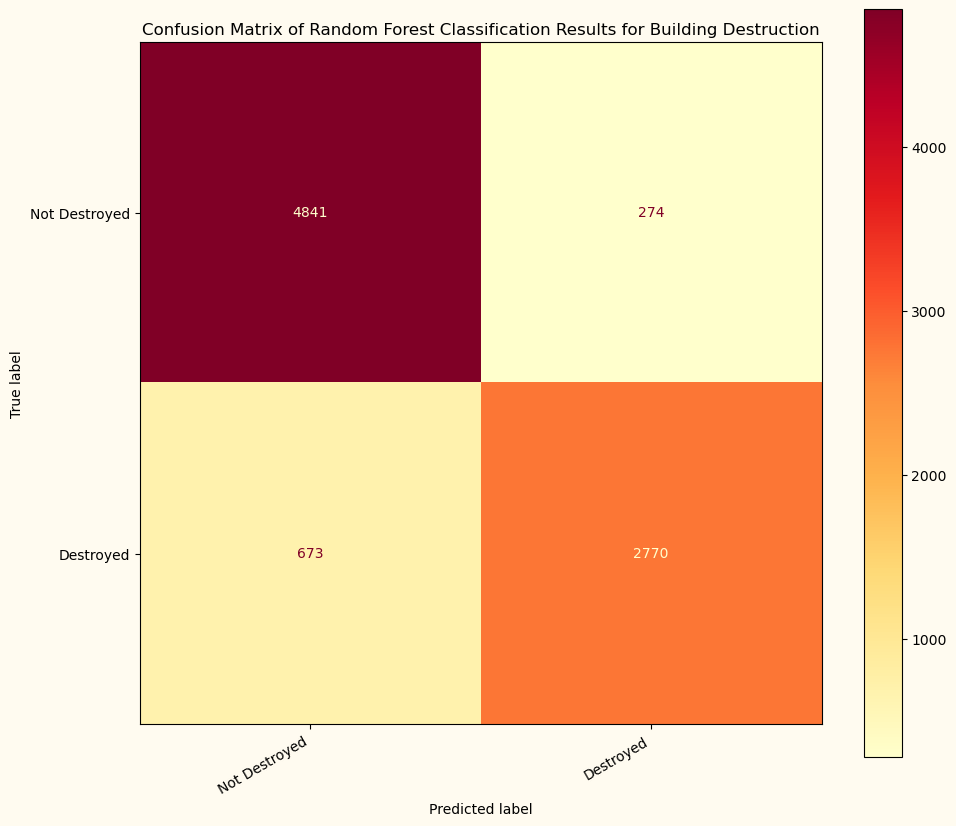

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

best_rf = grid_search_rf.best_estimator_
cm = confusion_matrix(y_test, y_rfpred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Destroyed', 'Destroyed'])
fig, ax = plt.subplots(figsize=(11, 11), facecolor = ('#fffbf0'))
disp.plot(ax=ax, cmap='YlOrRd')
fig.autofmt_xdate()
plt.title("Confusion Matrix of Random Forest Classification Results for Building Destruction")
plt.show()


We display feature importances for this model:

In [10]:
from IPython.display import display

# Use impurity-based feature importance (sum across all encodings for each feature)
importances = np.zeros(14)
importances[0] = np.sum(best_rf['classifier'].feature_importances_[0:16])
importances[1] = np.sum(best_rf['classifier'].feature_importances_[16:22])
importances[2] = np.sum(best_rf['classifier'].feature_importances_[22:25])
importances[3] = np.sum(best_rf['classifier'].feature_importances_[25:29])
importances[4] = np.sum(best_rf['classifier'].feature_importances_[29:37])
importances[5] = np.sum(best_rf['classifier'].feature_importances_[37:40])
importances[6] = np.sum(best_rf['classifier'].feature_importances_[40:44])
importances[7] = np.sum(best_rf['classifier'].feature_importances_[44:48])
importances[8] = np.sum(best_rf['classifier'].feature_importances_[48:51])
importances[9] = np.sum(best_rf['classifier'].feature_importances_[51:54])
importances[10:,] = best_rf['classifier'].feature_importances_[54:58]

# Create a new dataframe for feature importances across original feature columns and display it
feature_df = pd.DataFrame({'feature': original_columns[:-1], 'importance': importances})
display(feature_df)


,feature,importance
0,* Structure Type,0.039653
1,* Roof Construction,0.029040
2,* Eaves,0.022398
3,* Vent Screen,0.028771
4,* Exterior Siding,0.228754
5,* Window Pane,0.019201
6,* Deck/Porch On Grade,0.018017
7,* Deck/Porch Elevated,0.016117
8,* Patio Cover/Carport Attached to Structure,0.015839
9,* Fence Attached to Structure,0.022652


For this model, the most important features were longitude, exterior siding, and age.

Let's do some cross validation to test if we can increase performance by removing features.

In [11]:
from sklearn.model_selection import StratifiedKFold
n_splits = 5
kfold = StratifiedKFold(n_splits,
                            shuffle=True,
                            random_state=216)

y = fire_train['Destroyed']

avg_Accs = []
for c in cal_fire_data.columns[:-1]:   
    X = fire_train.drop(columns=['Destroyed',c])

    categorical_cols = X.select_dtypes(include='object').columns.tolist()

    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.difference(['Destroyed'])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
            ('scaler', StandardScaler(), numeric_cols)
        ],
        remainder='passthrough'  
    )

    rfpipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=8, random_state=216))
    ])

    param_grid = {
        'classifier__criterion': ['gini'],
        'classifier__max_depth': [5, 10, 15, 20, None],
        'classifier__min_samples_split': [2, 4, 6, 8, 10, 12],
        'classifier__min_samples_leaf': [1, 2, 4, 8]
    }

    accuracies = []

    for train_index, test_index in kfold.split(X,y):
        X_tt = X.iloc[train_index]
        y_tt = y.iloc[train_index]
        X_ho = X.iloc[test_index]
        y_ho = y.iloc[test_index]
        
        grid_search_rf = GridSearchCV(rfpipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
        grid_search_rf.fit(X_tt, y_tt)

        y_rfpred = grid_search_rf.best_estimator_.predict(X_ho)
        accuracies += [accuracy_score(y_ho, y_rfpred)]
    print('The avg accuracy when removing column', c, 'is', np.mean(accuracies),'\n')
    avg_Accs += [np.mean(accuracies)]

print('The maximum accuracy is', np.max(avg_Accs), 'and is attained when we remove column', cal_fire_data.columns[np.argmax(avg_Accs)])


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
The avg accuracy when removing column * Structure Type is 0.8841401696724122 

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
The avg accuracy when removing column * Roof Construction is 0.8824165525002666 

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for 

Removing any feature seams to decrease accuracy of the model. Let's keep them all then.